In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [3]:
# Set parameters
estimatorType='rnn' # kalman or rnn
seeAction=True
seeMeasurement=False
seeEstimate=False
T=12

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 800 samples, validate on 200 samples
Epoch 1/5
 - 37s - loss: 0.0857 - val_loss: 0.0501
Epoch 2/5
 - 34s - loss: 0.0327 - val_loss: 0.0271
Epoch 3/5
 - 33s - loss: 0.0271 - val_loss: 0.0251
Epoch 4/5
 - 37s - loss: 0.0260 - val_loss: 0.0245
Epoch 5/5
 - 33s - loss: 0.0254 - 

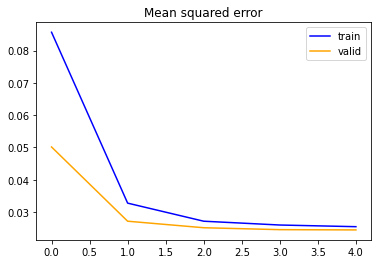

Done


In [ ]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=1000
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.3)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=5,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

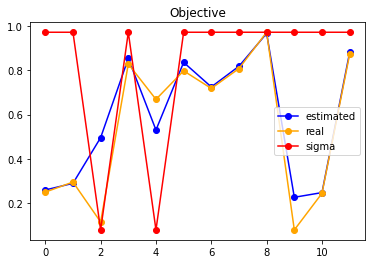

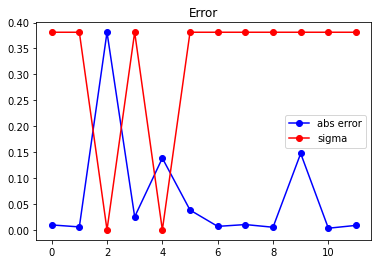

Done


In [ ]:
if estimatorType=='rnn':
    idx_sample=0
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN[idx_sample:(idx_sample+1),:,:])
    plotErrors(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

In [ ]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=5000, windowSize=4)
rewarder.summarize()

RNN estimator
observationsDimensions: [(5,)]
seeAction= True
seeMeasurement= False
seeEstimate= False
threshold rewarder
window size: 4
threshold: 2
cost: 5000
number of measures in the window: 0


In [ ]:
# generate sequences for training the agent
numberSamples_trainAgent=100
T_trainAgent=T

(objectives_trainAgent,measurements_trainAgent)=estimator.generateSequence(T_trainAgent,numberSamples=numberSamples_trainAgent)

print('shape objectives:',np.shape(objectives_trainAgent))
print('shape measurements:',np.shape(measurements_trainAgent))

shape objectives: (100, 12, 1)
shape measurements: (100, 12, 1)


In [ ]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_trainAgent,measurements_trainAgent)
print('Agent constructed')

Environment parameters
  REWARDER= <rewarders.thresholdRewarder.ThresholdRewarder object at 0xb377617b8>
  inputDimensions= [(5,)]
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 100
  n_dim_obj= 1
  n_dim_meas= 1
Agent constructed


In [ ]:
# Train agent
agent.run(n_epochs=40, epoch_length=numberSamples_trainAgent*T_trainAgent)
print('Agent Trained')

Average (on the epoch) training loss: 1894.0648193359375
Episode average V value: -0.04817802831530571
Average (on the epoch) training loss: 2569.172119140625
Episode average V value: -2.4834455139935017
Average (on the epoch) training loss: 2412.01025390625
Episode average V value: -23.68320655822754
Average (on the epoch) training loss: 2203.93115234375
Episode average V value: -86.18897088368733
Average (on the epoch) training loss: 2037.0311279296875
Episode average V value: -232.08731079101562
Average (on the epoch) training loss: 1878.819580078125
Episode average V value: -492.8666159889915
Average (on the epoch) training loss: 1731.111572265625
Episode average V value: -700.81201171875
Average (on the epoch) training loss: 1610.58056640625
Episode average V value: -576.2876841227213
Average (on the epoch) training loss: 1507.876953125
Episode average V value: -604.478515625
Average (on the epoch) training loss: 1409.14013671875
Episode average V value: -436.6860605875651
Average

Average (on the epoch) training loss: 309.2987976074219
Episode average V value: -1.5978328635295231
Average (on the epoch) training loss: 307.7052917480469
Episode average V value: 1.3474353551864624
Average (on the epoch) training loss: 306.14630126953125
Episode average V value: 7.650452574094136
Average (on the epoch) training loss: 304.7248840332031
Episode average V value: 41.31606674194336
Average (on the epoch) training loss: 303.37371826171875
Episode average V value: -56.52460296948751
Average (on the epoch) training loss: 301.7394714355469
Episode average V value: 70.5066146850586
Average (on the epoch) training loss: 300.8164978027344
Episode average V value: 60.640132904052734
Average (on the epoch) training loss: 298.80133056640625
Episode average V value: 61.522409200668335
Average (on the epoch) training loss: 296.5032653808594
Episode average V value: 43.18218994140625
Average (on the epoch) training loss: 294.8331604003906
Episode average V value: 35.1674690246582
Ave

Average (on the epoch) training loss: 92.86668395996094
Episode average V value: 19.303570573980156
Average (on the epoch) training loss: 92.72872161865234
Episode average V value: 11.674999809265136
Average (on the epoch) training loss: 92.44747161865234
Episode average V value: 2.86453777551651
Average (on the epoch) training loss: 92.29581451416016
Episode average V value: 9.749298969904581
Average (on the epoch) training loss: 92.32879638671875
Episode average V value: 26.89851188659668
Average (on the epoch) training loss: 92.35049438476562
Episode average V value: 29.575711647669475
Average (on the epoch) training loss: 91.882080078125
Episode average V value: 35.67307662963867
Average (on the epoch) training loss: 91.56815338134766
Episode average V value: 27.747344970703125
Average (on the epoch) training loss: 91.65155792236328
Episode average V value: 24.160741806030273
Average (on the epoch) training loss: 91.14521789550781
Episode average V value: 30.99127821488814
Average 

Average (on the epoch) training loss: 63.47405242919922
Episode average V value: 43.94885094960531
Average (on the epoch) training loss: 63.349220275878906
Episode average V value: 18.882275104522705
Average (on the epoch) training loss: 63.30827331542969
Episode average V value: 54.0766708056132
Average (on the epoch) training loss: 62.90920639038086
Episode average V value: 22.3977845509847
Average (on the epoch) training loss: 63.14262771606445
Episode average V value: 66.51914978027344
Average (on the epoch) training loss: 63.328102111816406
Episode average V value: 31.261088768641155
Average (on the epoch) training loss: 63.773983001708984
Episode average V value: 36.768590092659
Average (on the epoch) training loss: 63.429344177246094
Episode average V value: 35.76047255776145
Average (on the epoch) training loss: 63.798919677734375
Episode average V value: 56.10040283203125
Average (on the epoch) training loss: 63.34456253051758
Episode average V value: -2.155714770158132
Averag

Average (on the epoch) training loss: 62.65781021118164
Episode average V value: 49.78982663154602
Average (on the epoch) training loss: 62.57236862182617
Episode average V value: 49.57584762573242
Average (on the epoch) training loss: 62.5617561340332
Episode average V value: 102.22690996527672
Average (on the epoch) training loss: 62.976524353027344
Episode average V value: 78.62259674072266
Average (on the epoch) training loss: 62.53252410888672
Episode average V value: 51.40023465951284
Average (on the epoch) training loss: 62.72354507446289
Episode average V value: 65.95364548762639
Average (on the epoch) training loss: 62.54927444458008
Episode average V value: 33.11900075276693
Average (on the epoch) training loss: 63.945587158203125
Episode average V value: 43.378499031066895
Average (on the epoch) training loss: 64.2763900756836
Episode average V value: 80.2530746459961
Average (on the epoch) training loss: 65.47306823730469
Episode average V value: 42.99795913696289
Average (

Average (on the epoch) training loss: 81.20266723632812
Episode average V value: 93.16715208689372
Average (on the epoch) training loss: 81.85395050048828
Episode average V value: -300.29884974161786
Average (on the epoch) training loss: 80.44552612304688
Episode average V value: 105.36675707499187
Average (on the epoch) training loss: 81.5863265991211
Episode average V value: 95.67482063987039
Average (on the epoch) training loss: 80.82276153564453
Episode average V value: 118.49162292480469
Average (on the epoch) training loss: 83.78852844238281
Episode average V value: 75.05667114257812
Average (on the epoch) training loss: 84.65139770507812
Episode average V value: 78.7306900024414
Average (on the epoch) training loss: 84.5966796875
Episode average V value: 96.35588455200195
Average (on the epoch) training loss: 85.0436782836914
Episode average V value: 98.5308609008789
Average (on the epoch) training loss: 85.38430786132812
Episode average V value: 97.52469635009766
Average (on th

Average (on the epoch) training loss: 84.59333038330078
Episode average V value: 100.20095825195312
Average (on the epoch) training loss: 84.9502182006836
Episode average V value: 91.32173156738281
epoch 6:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Average (on the epoch) training loss: 65.29666900634766
Episode average V value: -725.9062407811483
Average (on the epoch) training loss: 95.23604583740234
Episode average V value: 76.91515167554219
Average (on the epoch) training loss: 83.3168716430664
Episode average V value: 75.9277572631836
Average (on the epoch) training loss: 89.28401947021484
Episode average V value: 69.29139232635498
Average (on the epoch) training loss: 91.89376068115234
Episode average V value: 75.55621385574341
Average (on the epoch) training loss: 97.86827087402344
Episode average V value: 73.97622680664062
Average (on the epoch) training loss: 98.09765625
Episode average V value: 80.45072174072266
Average (on the epoch) training loss: 96.17989349365

Average (on the epoch) training loss: 75.3310775756836
Episode average V value: -369.92318773269653
Average (on the epoch) training loss: 75.0867691040039
Episode average V value: 62.84136962890625
Average (on the epoch) training loss: 75.6839370727539
Episode average V value: 71.86604309082031
Average (on the epoch) training loss: 76.04191589355469
Episode average V value: 40.00114711125692
Average (on the epoch) training loss: 75.579345703125
Episode average V value: 31.402618408203125
Average (on the epoch) training loss: 75.70256042480469
Episode average V value: 36.085848569869995
Average (on the epoch) training loss: 75.51461791992188
Episode average V value: 28.45739747087161
Average (on the epoch) training loss: 75.8138198852539
Episode average V value: 43.452407121658325
Average (on the epoch) training loss: 75.56057739257812
Episode average V value: 49.3690071105957
Average (on the epoch) training loss: 76.139892578125
Episode average V value: 47.34132512410482
Average (on th

Average (on the epoch) training loss: 67.50959777832031
Episode average V value: -374.78287744522095
Average (on the epoch) training loss: 67.533935546875
Episode average V value: 44.83186423778534
Average (on the epoch) training loss: 68.04953002929688
Episode average V value: 26.76103909810384
Average (on the epoch) training loss: 68.51844024658203
Episode average V value: 52.830758253733315
Average (on the epoch) training loss: 68.30020141601562
Episode average V value: 40.79864163832231
Average (on the epoch) training loss: 68.55631256103516
Episode average V value: 38.62673234939575
Average (on the epoch) training loss: 68.68193054199219
Episode average V value: 47.915828704833984
Average (on the epoch) training loss: 68.51582336425781
Episode average V value: 31.697423299153645
Average (on the epoch) training loss: 68.3259506225586
Episode average V value: 46.01983226429332
Average (on the epoch) training loss: 68.18515014648438
Episode average V value: 31.73385492960612
Average 

Average (on the epoch) training loss: 60.15327453613281
Episode average V value: 79.31856536865234
Average (on the epoch) training loss: 59.960975646972656
Episode average V value: 52.43359375
Average (on the epoch) training loss: 60.767181396484375
Episode average V value: 71.31851804256439
Average (on the epoch) training loss: 60.3735237121582
Episode average V value: 28.454360783100128
Average (on the epoch) training loss: 60.27260971069336
Episode average V value: 53.75787480672201
Average (on the epoch) training loss: 59.93838119506836
Episode average V value: 43.944031715393066
Average (on the epoch) training loss: 59.30061721801758
Episode average V value: 36.88808059692383
Average (on the epoch) training loss: 59.42716598510742
Episode average V value: 39.971830974925645
Average (on the epoch) training loss: 60.789119720458984
Episode average V value: 36.21936321258545
Average (on the epoch) training loss: 60.20027542114258
Episode average V value: 33.0228157043457
Average (on 

Average (on the epoch) training loss: 57.36750793457031
Episode average V value: 26.56163191795349
Average (on the epoch) training loss: 56.95487976074219
Episode average V value: 35.08120699723562
Average (on the epoch) training loss: 57.46983337402344
Episode average V value: 45.38765001296997
Average (on the epoch) training loss: 58.60548782348633
Episode average V value: 36.41127395629883
Average (on the epoch) training loss: 57.97949981689453
Episode average V value: 57.041839599609375
Average (on the epoch) training loss: 58.37285614013672
Episode average V value: 55.3868293762207
Average (on the epoch) training loss: 59.84027099609375
Episode average V value: 41.36197073260943
Average (on the epoch) training loss: 60.12434768676758
Episode average V value: 49.79853439331055
Average (on the epoch) training loss: 60.00923156738281
Episode average V value: -344.36647349596024
Average (on the epoch) training loss: 60.47171401977539
Episode average V value: 30.516556653109465
Average

Average (on the epoch) training loss: 81.4020004272461
Episode average V value: 34.33161544799805
Average (on the epoch) training loss: 83.42073822021484
Episode average V value: 59.04407835006714
Average (on the epoch) training loss: 84.36531829833984
Episode average V value: 45.64945602416992
Average (on the epoch) training loss: 81.44847106933594
Episode average V value: 54.014984130859375
Average (on the epoch) training loss: 81.2535629272461
Episode average V value: 76.59064483642578
Average (on the epoch) training loss: 78.89183807373047
Episode average V value: 26.390718460083008
Average (on the epoch) training loss: 79.14859771728516
Episode average V value: 38.973697443803154
Average (on the epoch) training loss: 77.26348876953125
Episode average V value: 37.206997553507485
Average (on the epoch) training loss: 79.15388488769531
Episode average V value: 43.7974495454268
Average (on the epoch) training loss: 78.08438873291016
Episode average V value: 57.127227783203125
Average 

Average (on the epoch) training loss: 67.33709716796875
Episode average V value: 39.90724563598633
Average (on the epoch) training loss: 67.1836166381836
Episode average V value: 30.24442179997762
Average (on the epoch) training loss: 67.19612121582031
Episode average V value: 42.60039043426514
epoch 11:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Average (on the epoch) training loss: 71.62702941894531
Episode average V value: 45.00735092163086
Average (on the epoch) training loss: 70.91973114013672
Episode average V value: 50.29875564575195
Average (on the epoch) training loss: 65.00467681884766
Episode average V value: 47.62528053919474
Average (on the epoch) training loss: 61.585391998291016
Episode average V value: 51.60258865356445
Average (on the epoch) training loss: 69.90634155273438
Episode average V value: 42.92911911010742
Average (on the epoch) training loss: 73.09326171875
Episode average V value: 44.52664852142334
Average (on the epoch) training loss: 71.284248

Average (on the epoch) training loss: 59.043270111083984
Episode average V value: 54.6661262512207
Average (on the epoch) training loss: 58.91075134277344
Episode average V value: 37.636566162109375
Average (on the epoch) training loss: 58.59156036376953
Episode average V value: 45.04707336425781
Average (on the epoch) training loss: 58.51276779174805
Episode average V value: 60.760842641194664
Average (on the epoch) training loss: 58.32901382446289
Episode average V value: 28.108295838038128
Average (on the epoch) training loss: 58.081417083740234
Episode average V value: 52.77542118231455
Average (on the epoch) training loss: 58.32322311401367
Episode average V value: 45.20811080932617
Average (on the epoch) training loss: 58.416259765625
Episode average V value: 41.741665840148926
Average (on the epoch) training loss: 58.63760757446289
Episode average V value: 39.64054250717163
Average (on the epoch) training loss: 58.38371658325195
Episode average V value: 46.034573793411255
Averag

Average (on the epoch) training loss: 54.09965133666992
Episode average V value: 39.994371760975234
Average (on the epoch) training loss: 54.49409103393555
Episode average V value: 49.65011215209961
Average (on the epoch) training loss: 54.38311004638672
Episode average V value: 48.605159759521484
Average (on the epoch) training loss: 55.03810119628906
Episode average V value: 53.939632415771484
Average (on the epoch) training loss: 55.879032135009766
Episode average V value: 51.944644927978516
Average (on the epoch) training loss: 56.002586364746094
Episode average V value: 29.6720684224909
Average (on the epoch) training loss: 55.583900451660156
Episode average V value: 31.45619010925293
Average (on the epoch) training loss: 56.032718658447266
Episode average V value: 25.30464267730713
Average (on the epoch) training loss: 55.93904113769531
Episode average V value: 22.398025174935658
Average (on the epoch) training loss: 56.83140182495117
Episode average V value: 31.607635498046875
A

Average (on the epoch) training loss: 51.05746078491211
Episode average V value: 29.718026280403137
Average (on the epoch) training loss: 50.59102249145508
Episode average V value: 44.17812728881836
Average (on the epoch) training loss: 50.33354187011719
Episode average V value: 23.82292014360428
Average (on the epoch) training loss: 50.958709716796875
Episode average V value: 39.59566593170166
Average (on the epoch) training loss: 50.67232894897461
Episode average V value: 25.190497875213623
Average (on the epoch) training loss: 51.02597427368164
Episode average V value: 49.63363301257292
Average (on the epoch) training loss: 52.17100524902344
Episode average V value: 25.709789514541626
Average (on the epoch) training loss: 52.00205612182617
Episode average V value: 25.119489510854084
Average (on the epoch) training loss: 52.214603424072266
Episode average V value: 19.406147638956707
Average (on the epoch) training loss: 52.33021926879883
Episode average V value: 22.34107192357381
Ave

Average (on the epoch) training loss: 45.69853973388672
Episode average V value: 33.64377212524414
Average (on the epoch) training loss: 45.261322021484375
Episode average V value: 38.540653402155094
Average (on the epoch) training loss: 46.734619140625
Episode average V value: -394.87223927179974
Average (on the epoch) training loss: 46.61703872680664
Episode average V value: 25.999353408813477
Average (on the epoch) training loss: 48.223419189453125
Episode average V value: 33.88415756225586
Average (on the epoch) training loss: 48.590919494628906
Episode average V value: 19.402942260106403
Average (on the epoch) training loss: 48.741886138916016
Episode average V value: 34.015503803888954
Average (on the epoch) training loss: 50.041866302490234
Episode average V value: -360.06025791168213
Average (on the epoch) training loss: 49.73640060424805
Episode average V value: 33.80784821510315
Average (on the epoch) training loss: 49.49700164794922
Episode average V value: 65.7295405069987


Average (on the epoch) training loss: 57.114315032958984
Episode average V value: 42.137146949768066
Average (on the epoch) training loss: 56.05546951293945
Episode average V value: -374.64586051305133
Average (on the epoch) training loss: 58.57789611816406
Episode average V value: 33.99874477386474
Average (on the epoch) training loss: 58.94542694091797
Episode average V value: 43.154738108317055
Average (on the epoch) training loss: 58.74958038330078
Episode average V value: 48.4216423034668
Average (on the epoch) training loss: 58.43504333496094
Episode average V value: 27.344932635625202
Average (on the epoch) training loss: 56.94786071777344
Episode average V value: 42.972964922587074
Average (on the epoch) training loss: 57.04656982421875
Episode average V value: 24.976035435994465
Average (on the epoch) training loss: 56.67869567871094
Episode average V value: 42.963218569755554
Average (on the epoch) training loss: 54.993377685546875
Episode average V value: 50.75327682495117
A

Average (on the epoch) training loss: 63.19172668457031
Episode average V value: 59.30038070678711
Average (on the epoch) training loss: 63.44999313354492
Episode average V value: 47.864654541015625
Average (on the epoch) training loss: 63.19102096557617
Episode average V value: 42.04268264770508
Average (on the epoch) training loss: 62.89556121826172
Episode average V value: 32.97852555910746
Average (on the epoch) training loss: 62.96758270263672
Episode average V value: 45.55530961354574
Average (on the epoch) training loss: 62.81291198730469
Episode average V value: 46.81363836924235
Average (on the epoch) training loss: 62.67603302001953
Episode average V value: 35.55115925181996
Average (on the epoch) training loss: 62.4882926940918
Episode average V value: 44.17146301269531
epoch 16:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Average (on the epoch) training loss: 87.39464569091797
Episode average V value: 34.38514280319214
Average (on the epoch) training loss: 59.336

Average (on the epoch) training loss: 50.15022659301758
Episode average V value: 22.095293045043945
Average (on the epoch) training loss: 49.86962127685547
Episode average V value: 25.119464715321858
Average (on the epoch) training loss: 50.374515533447266
Episode average V value: 35.396976470947266
Average (on the epoch) training loss: 49.944332122802734
Episode average V value: 29.296031951904297
Average (on the epoch) training loss: 49.78125
Episode average V value: 26.8666733900706
Average (on the epoch) training loss: 50.2510986328125
Episode average V value: 25.610807418823242
Average (on the epoch) training loss: 49.857704162597656
Episode average V value: 24.08190155029297
Average (on the epoch) training loss: 49.680870056152344
Episode average V value: -399.95844487349194
Average (on the epoch) training loss: 49.416038513183594
Episode average V value: 29.849975152449176
Average (on the epoch) training loss: 49.4018669128418
Episode average V value: -390.80822738011676
Average

Average (on the epoch) training loss: 56.380882263183594
Episode average V value: 23.25881924231847
Average (on the epoch) training loss: 56.40375518798828
Episode average V value: 26.00549300511678
Average (on the epoch) training loss: 57.352420806884766
Episode average V value: 29.294567902882893
Average (on the epoch) training loss: 57.422218322753906
Episode average V value: 28.74315071105957
Average (on the epoch) training loss: 57.6107292175293
Episode average V value: 19.86142764488856
Average (on the epoch) training loss: 57.990509033203125
Episode average V value: 22.50555729866028
Average (on the epoch) training loss: 58.2393684387207
Episode average V value: 33.03926086425781
Average (on the epoch) training loss: 58.774131774902344
Episode average V value: 35.581670024178244
Average (on the epoch) training loss: 59.43765640258789
Episode average V value: 29.07986068725586
Average (on the epoch) training loss: 58.89793395996094
Episode average V value: 31.953367233276367
Aver

Average (on the epoch) training loss: 53.36042785644531
Episode average V value: 55.8052864074707
Average (on the epoch) training loss: 54.09687423706055
Episode average V value: 39.982714080810545
Average (on the epoch) training loss: 54.10044479370117
Episode average V value: 33.40833520889282
Average (on the epoch) training loss: 54.44918441772461
Episode average V value: 51.39921951293945
Average (on the epoch) training loss: 55.57951736450195
Episode average V value: 24.812538623809814
Average (on the epoch) training loss: 56.25829315185547
Episode average V value: 33.69963836669922
Average (on the epoch) training loss: 56.181087493896484
Episode average V value: 49.2635498046875
Average (on the epoch) training loss: 57.8163948059082
Episode average V value: 48.95960831642151
Average (on the epoch) training loss: 57.47121810913086
Episode average V value: 39.87358792622884
Average (on the epoch) training loss: 56.86745834350586
Episode average V value: 43.512195428212486
Average (

Average (on the epoch) training loss: 61.121150970458984
Episode average V value: 42.78361129760742
Average (on the epoch) training loss: 60.04216766357422
Episode average V value: 49.23137458165487
Average (on the epoch) training loss: 58.862056732177734
Episode average V value: 47.98471530278524
Average (on the epoch) training loss: 59.39739227294922
Episode average V value: 54.3553581237793
Average (on the epoch) training loss: 59.72944259643555
Episode average V value: -366.7395981152852
Average (on the epoch) training loss: 60.190940856933594
Episode average V value: 38.6330197652181
Average (on the epoch) training loss: 61.07038116455078
Episode average V value: 39.10771338144938
Average (on the epoch) training loss: 60.76454544067383
Episode average V value: 47.94438171386719
Average (on the epoch) training loss: 61.9527473449707
Episode average V value: 39.541986812244765
Average (on the epoch) training loss: 60.81193923950195
Episode average V value: 35.77406565348307
Average 

Average (on the epoch) training loss: 38.77703094482422
Episode average V value: 34.04920895894369
Average (on the epoch) training loss: 53.440399169921875
Episode average V value: 32.754078431562945
Average (on the epoch) training loss: 52.192626953125
Episode average V value: 16.39516830444336
Average (on the epoch) training loss: 51.05598831176758
Episode average V value: 20.803284072875975
Average (on the epoch) training loss: 53.36241149902344
Episode average V value: 33.221900939941406
Average (on the epoch) training loss: 60.639102935791016
Episode average V value: 22.516154607137043
Average (on the epoch) training loss: 67.06539916992188
Episode average V value: 22.52582319577535
Average (on the epoch) training loss: 63.73966979980469
Episode average V value: 32.458683013916016
Average (on the epoch) training loss: 62.01349639892578
Episode average V value: 21.59158420562744
Average (on the epoch) training loss: 61.18341827392578
Episode average V value: 23.65837589899699
Avera

Average (on the epoch) training loss: 46.322181701660156
Episode average V value: 22.360873381296795
Average (on the epoch) training loss: 46.06017303466797
Episode average V value: 31.906602382659912
Average (on the epoch) training loss: 45.81264114379883
Episode average V value: 21.490869522094727
Average (on the epoch) training loss: 46.13246536254883
Episode average V value: 40.4629545211792
Average (on the epoch) training loss: 46.431610107421875
Episode average V value: 20.368383407592773
Average (on the epoch) training loss: 46.67495346069336
Episode average V value: 20.07148504257202
Average (on the epoch) training loss: 46.408843994140625
Episode average V value: 20.595839897791546
Average (on the epoch) training loss: 46.16316223144531
Episode average V value: 32.85135269165039
Average (on the epoch) training loss: 45.94765853881836
Episode average V value: -383.7123688062032
Average (on the epoch) training loss: 45.85418701171875
Episode average V value: 27.689322471618652
A

Average (on the epoch) training loss: 60.469608306884766
Episode average V value: 21.82707405090332
Average (on the epoch) training loss: 60.08086395263672
Episode average V value: 16.75739860534668
Average (on the epoch) training loss: 59.990631103515625
Episode average V value: 20.90416669845581
Average (on the epoch) training loss: 60.65269088745117
Episode average V value: 12.693530102570852
Average (on the epoch) training loss: 60.713294982910156
Episode average V value: 13.921986480553945
Average (on the epoch) training loss: 60.63002395629883
Episode average V value: 19.796145005659625
Average (on the epoch) training loss: 60.21002197265625
Episode average V value: 28.876571257909138
Average (on the epoch) training loss: 60.1147575378418
Episode average V value: 6.5152520934740705
Average (on the epoch) training loss: 59.63789749145508
Episode average V value: 27.026474316914875
Average (on the epoch) training loss: 59.6220703125
Episode average V value: 21.33261251449585
Averag

Average (on the epoch) training loss: 50.57412338256836
Episode average V value: 36.588417053222656
Average (on the epoch) training loss: 50.717227935791016
Episode average V value: 17.611827214558918
Average (on the epoch) training loss: 50.680259704589844
Episode average V value: 18.33695848782857
Average (on the epoch) training loss: 50.40119934082031
Episode average V value: 27.321935335795086
Average (on the epoch) training loss: 50.232845306396484
Episode average V value: 30.617124557495117
Average (on the epoch) training loss: 49.709007263183594
Episode average V value: 21.86412239074707
Average (on the epoch) training loss: 50.12919616699219
Episode average V value: 43.40615463256836
Average (on the epoch) training loss: 50.2187385559082
Episode average V value: 9.351463586091995
Average (on the epoch) training loss: 49.76298904418945
Episode average V value: 24.796812057495117
Average (on the epoch) training loss: 49.276058197021484
Episode average V value: 19.316015243530273


Average (on the epoch) training loss: 49.20543670654297
Episode average V value: 34.47731399536133
Average (on the epoch) training loss: 48.590362548828125
Episode average V value: 31.01902421315511
Average (on the epoch) training loss: 47.91041946411133
Episode average V value: 36.290252685546875
Average (on the epoch) training loss: 47.483558654785156
Episode average V value: 13.044699430465698
Average (on the epoch) training loss: 47.01255416870117
Episode average V value: 23.1697980707342
Average (on the epoch) training loss: 48.859004974365234
Episode average V value: 42.330196380615234
Average (on the epoch) training loss: 48.574310302734375
Episode average V value: 30.007234573364258
Average (on the epoch) training loss: 48.030582427978516
Episode average V value: 35.05106512705485
Average (on the epoch) training loss: 47.51856994628906
Episode average V value: 36.80037307739258
Average (on the epoch) training loss: 47.2484130859375
Episode average V value: 34.564175844192505
Av

Average (on the epoch) training loss: 41.75148391723633
Episode average V value: 4.6952775319417315
Average (on the epoch) training loss: 40.925994873046875
Episode average V value: 16.983339023590087
Average (on the epoch) training loss: 42.97600173950195
Episode average V value: 27.77533531188965
Average (on the epoch) training loss: 42.53477478027344
Episode average V value: 22.341249465942383
Average (on the epoch) training loss: 41.768280029296875
Episode average V value: 38.958412170410156
Average (on the epoch) training loss: 41.12686538696289
Episode average V value: 28.022803783416748
Average (on the epoch) training loss: 40.62032699584961
Episode average V value: 38.637006759643555
Average (on the epoch) training loss: 40.158729553222656
Episode average V value: 29.174771915782582
Average (on the epoch) training loss: 39.529212951660156
Episode average V value: 35.23057174682617
Average (on the epoch) training loss: 40.63482666015625
Episode average V value: 29.03686714172363

Average (on the epoch) training loss: 64.46599578857422
Episode average V value: 36.26713991165161
Average (on the epoch) training loss: 69.19392395019531
Episode average V value: 37.9981575012207
Average (on the epoch) training loss: 66.73422241210938
Episode average V value: 39.43373425801595
Average (on the epoch) training loss: 68.93904113769531
Episode average V value: 35.55604684352875
Average (on the epoch) training loss: 63.675811767578125
Episode average V value: 38.11511115233103
Average (on the epoch) training loss: 59.83346939086914
Episode average V value: 62.760643005371094
Average (on the epoch) training loss: 57.965877532958984
Episode average V value: 38.658013343811035
Average (on the epoch) training loss: 58.22492599487305
Episode average V value: 63.50948715209961
Average (on the epoch) training loss: 59.90080261230469
Episode average V value: -368.85285870234173
Average (on the epoch) training loss: 57.20407485961914
Episode average V value: 39.170713583628334
Aver

Average (on the epoch) training loss: 48.962646484375
Episode average V value: 19.589228848616283
Average (on the epoch) training loss: 48.730430603027344
Episode average V value: 25.248184204101562
Average (on the epoch) training loss: 48.715972900390625
Episode average V value: 27.98136027654012
Average (on the epoch) training loss: 48.4735107421875
Episode average V value: 17.89497725168864
Average (on the epoch) training loss: 48.259090423583984
Episode average V value: 49.2231559753418
Average (on the epoch) training loss: 47.99675750732422
Episode average V value: 34.637304147084556
Average (on the epoch) training loss: 48.3638801574707
Episode average V value: 44.79428482055664
Average (on the epoch) training loss: 48.58712387084961
Episode average V value: 24.621301849683125
Average (on the epoch) training loss: 48.75733947753906
Episode average V value: 22.83411979675293
Average (on the epoch) training loss: 49.02885437011719
Episode average V value: 42.5494270324707
Average (

Average (on the epoch) training loss: 43.84640121459961
Episode average V value: 9.874221404393515
Average (on the epoch) training loss: 44.47951126098633
Episode average V value: 28.605846007664997
Average (on the epoch) training loss: 44.661258697509766
Episode average V value: 22.603634516398113
Average (on the epoch) training loss: 44.73025894165039
Episode average V value: 12.415432532628378
Average (on the epoch) training loss: 44.7287483215332
Episode average V value: 15.600946108500162
Average (on the epoch) training loss: 44.42298126220703
Episode average V value: 22.54360095659892
Average (on the epoch) training loss: 44.53557205200195
Episode average V value: 27.826505661010742
Average (on the epoch) training loss: 44.92509078979492
Episode average V value: 22.31331737836202
Average (on the epoch) training loss: 44.90642166137695
Episode average V value: 22.56621825695038
Average (on the epoch) training loss: 44.77047348022461
Episode average V value: 19.260286887486775
Aver

Average (on the epoch) training loss: 53.069698333740234
Episode average V value: 43.54972354571024
Average (on the epoch) training loss: 52.563507080078125
Episode average V value: 43.63456789652506
Average (on the epoch) training loss: 52.22216033935547
Episode average V value: 56.95476150512695
Average (on the epoch) training loss: 51.886417388916016
Episode average V value: 32.98516448338827
Average (on the epoch) training loss: 51.44744110107422
Episode average V value: 38.743284463882446
Average (on the epoch) training loss: 51.29120635986328
Episode average V value: 35.92461013793945
Average (on the epoch) training loss: 51.034912109375
Episode average V value: 46.49124256769816
Average (on the epoch) training loss: 51.95368957519531
Episode average V value: -380.2001416683197
Average (on the epoch) training loss: 52.71112060546875
Episode average V value: 36.220975485715
Average (on the epoch) training loss: 52.693485260009766
Episode average V value: 23.066969752311707
Average

Average (on the epoch) training loss: 63.05891799926758
Episode average V value: 42.50988974571228
Average (on the epoch) training loss: 63.72191619873047
Episode average V value: 32.79009654305198
Average (on the epoch) training loss: 63.69855499267578
Episode average V value: 36.83121236165365
Average (on the epoch) training loss: 65.13941192626953
Episode average V value: 42.18209457397461
Average (on the epoch) training loss: 65.155517578125
Episode average V value: 45.716328938802086
Average (on the epoch) training loss: 64.95555114746094
Episode average V value: 36.592124938964844
Average (on the epoch) training loss: 64.91931915283203
Episode average V value: 41.608943939208984
Average (on the epoch) training loss: 65.15007781982422
Episode average V value: 42.21567153930664
Average (on the epoch) training loss: 64.97177124023438
Episode average V value: 40.815566619237266
Average (on the epoch) training loss: 66.08026123046875
Episode average V value: 46.14744520187378
Average 

Average (on the epoch) training loss: 57.70508575439453
Episode average V value: 42.14656396706899
Average (on the epoch) training loss: 57.79266357421875
Episode average V value: 50.22248331705729
Average (on the epoch) training loss: 56.817928314208984
Episode average V value: 62.818617502848305
Average (on the epoch) training loss: 57.91585159301758
Episode average V value: 58.446564356486
Average (on the epoch) training loss: 56.68095016479492
Episode average V value: 42.21980667114258
Average (on the epoch) training loss: 55.87140655517578
Episode average V value: 42.35929218928019
Average (on the epoch) training loss: 56.66400909423828
Episode average V value: 49.26952624320984
Average (on the epoch) training loss: 55.982696533203125
Episode average V value: 44.410640716552734
Average (on the epoch) training loss: 55.37922668457031
Episode average V value: 29.979715607383035
Average (on the epoch) training loss: 55.668235778808594
Episode average V value: 52.80414835611979
Averag

Average (on the epoch) training loss: 31.994157791137695
Episode average V value: 24.42313226064046
Average (on the epoch) training loss: 46.13079833984375
Episode average V value: 31.262670516967773
Average (on the epoch) training loss: 45.79026412963867
Episode average V value: 35.7094612121582
Average (on the epoch) training loss: 47.22045135498047
Episode average V value: 36.05006082852682
Average (on the epoch) training loss: 44.650856018066406
Episode average V value: 32.91910990079244
Average (on the epoch) training loss: 41.73149490356445
Episode average V value: 39.73108943303426
Average (on the epoch) training loss: 46.9461784362793
Episode average V value: 48.27577416102091
Average (on the epoch) training loss: 48.10531997680664
Episode average V value: 34.87656784057617
Average (on the epoch) training loss: 46.559608459472656
Episode average V value: 28.858626127243042
Average (on the epoch) training loss: 44.70327377319336
Episode average V value: 42.02667681376139
Average

Average (on the epoch) training loss: 54.1907958984375
Episode average V value: 27.343271255493164
Average (on the epoch) training loss: 53.837127685546875
Episode average V value: 28.3065007130305
Average (on the epoch) training loss: 53.73112869262695
Episode average V value: 37.835792541503906
Average (on the epoch) training loss: 53.33122634887695
Episode average V value: 22.352969566981
Average (on the epoch) training loss: 52.988922119140625
Episode average V value: -401.6650704542796
Average (on the epoch) training loss: 52.70596694946289
Episode average V value: 29.484888076782227
Average (on the epoch) training loss: 53.0770149230957
Episode average V value: 25.69058585166931
Average (on the epoch) training loss: 52.68324279785156
Episode average V value: 19.229456802209217
Average (on the epoch) training loss: 52.64950180053711
Episode average V value: 29.17613983154297
Average (on the epoch) training loss: 52.50039291381836
Episode average V value: 26.523170731284402
Average

Average (on the epoch) training loss: 63.11646270751953
Episode average V value: 45.55009651184082
Average (on the epoch) training loss: 62.64283752441406
Episode average V value: 43.35884111577814
Average (on the epoch) training loss: 62.39244079589844
Episode average V value: 52.43679428100586
Average (on the epoch) training loss: 61.99277877807617
Episode average V value: 49.146493673324585
Average (on the epoch) training loss: 61.54800796508789
Episode average V value: 46.045309702555336
Average (on the epoch) training loss: 61.89189147949219
Episode average V value: 39.631367206573486
Average (on the epoch) training loss: 61.90278625488281
Episode average V value: 43.40885543823242
Average (on the epoch) training loss: 61.87066650390625
Episode average V value: 43.644361114501955
Average (on the epoch) training loss: 61.642982482910156
Episode average V value: 42.10345458984375
Average (on the epoch) training loss: 61.21910095214844
Episode average V value: 47.310658888383344
Aver

Average (on the epoch) training loss: 40.78338623046875
Episode average V value: 29.726685603459675
Average (on the epoch) training loss: 41.37445831298828
Episode average V value: 23.021490693092346
Average (on the epoch) training loss: 41.773780822753906
Episode average V value: 30.732916196187336
Average (on the epoch) training loss: 41.554988861083984
Episode average V value: 35.74079895019531
Average (on the epoch) training loss: 42.06673812866211
Episode average V value: 28.159842491149902
Average (on the epoch) training loss: 41.76339340209961
Episode average V value: 31.855865478515625
Average (on the epoch) training loss: 41.94931411743164
Episode average V value: 31.505186875661213
Average (on the epoch) training loss: 42.460227966308594
Episode average V value: 24.23155379295349
Average (on the epoch) training loss: 42.55390167236328
Episode average V value: 33.163126389185585
Average (on the epoch) training loss: 42.63713455200195
Episode average V value: 28.84549903869629


Average (on the epoch) training loss: 45.14918899536133
Episode average V value: 33.77649766748602
Average (on the epoch) training loss: 44.59389114379883
Episode average V value: 49.78413009643555
Average (on the epoch) training loss: 46.536800384521484
Episode average V value: 35.21331230799357
Average (on the epoch) training loss: 47.14873123168945
Episode average V value: 35.18899345397949
Average (on the epoch) training loss: 47.076507568359375
Episode average V value: 42.68622016906738
Average (on the epoch) training loss: 47.41560745239258
Episode average V value: 48.7790412902832
Average (on the epoch) training loss: 48.303897857666016
Episode average V value: 44.897032737731934
Average (on the epoch) training loss: 47.85702896118164
Episode average V value: 46.2844352722168
Average (on the epoch) training loss: 47.888694763183594
Episode average V value: 60.40451431274414
Average (on the epoch) training loss: 47.34248733520508
Episode average V value: 42.16225814819336
Average

Average (on the epoch) training loss: 48.59899139404297
Episode average V value: 16.21338725090027
Average (on the epoch) training loss: 49.99076843261719
Episode average V value: 24.814834594726562
Average (on the epoch) training loss: 51.17871856689453
Episode average V value: 19.702256361643474
Average (on the epoch) training loss: 50.440372467041016
Episode average V value: 16.4738982518514
Average (on the epoch) training loss: 49.398590087890625
Episode average V value: 28.042593955993652
Average (on the epoch) training loss: 50.15193557739258
Episode average V value: 27.053451538085938
Average (on the epoch) training loss: 51.941184997558594
Episode average V value: 25.7850341796875
Average (on the epoch) training loss: 52.65597152709961
Episode average V value: 22.268836975097656
Average (on the epoch) training loss: 52.05412673950195
Episode average V value: 26.195013999938965
Average (on the epoch) training loss: 50.81664276123047
Episode average V value: 22.9883527358373
Aver

Average (on the epoch) training loss: 45.18681716918945
Episode average V value: 19.13071060180664
epoch 35:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
Average (on the epoch) training loss: 68.5705337524414
Episode average V value: 20.56004524230957
Average (on the epoch) training loss: 40.88493728637695
Episode average V value: 14.094719886779785
Average (on the epoch) training loss: 65.23153686523438
Episode average V value: 29.82871437072754
Average (on the epoch) training loss: 64.36961364746094
Episode average V value: 15.416409427469427
Average (on the epoch) training loss: 58.559452056884766
Episode average V value: 14.248237868150076
Average (on the epoch) training loss: 54.44569778442383
Episode average V value: 22.732833862304688
Average (on the epoch) training loss: 49.188446044921875
Episode average V value: 28.039052963256836
Average (on the epoch) training loss: 51.55450439453125
Episode average V value: 22.353639602661133
Average (on the epoch) training loss:

Average (on the epoch) training loss: 42.72103500366211
Episode average V value: 22.0566463470459
Average (on the epoch) training loss: 43.214359283447266
Episode average V value: 19.05458554354581
Average (on the epoch) training loss: 43.59043884277344
Episode average V value: 16.083146413167317
Average (on the epoch) training loss: 43.809913635253906
Episode average V value: 19.73652712504069
Average (on the epoch) training loss: 43.76011276245117
Episode average V value: 21.94398359818892
Average (on the epoch) training loss: 44.1307258605957
Episode average V value: 19.32749040921529
Average (on the epoch) training loss: 44.56980895996094
Episode average V value: 28.13748654452237
Average (on the epoch) training loss: 44.32625961303711
Episode average V value: 15.901372035344442
Average (on the epoch) training loss: 44.04007339477539
Episode average V value: 15.832846959431967
Average (on the epoch) training loss: 43.74894332885742
Episode average V value: 20.739064931869507
Averag

In [ ]:
# generate test data
numberSamples_test=10
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)

In [ ]:
idx_sample=0
plotErrors(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)